# Deflection Profile Parametric Study
This file presents a parametric study based on the Deflection-Profile implementation provided in the file "deflection_profile.py" of the bmcs_beam package.

In [1]:
%matplotlib inline

In [2]:
from bmcs_cross_section.mkappa import MKappa
from bmcs_beam.beam_config.boundary_conditions import BoundaryConditions
from bmcs_beam.bending.deflection_profile import DeflectionProfile
from bmcs_beam.beam_config.beam_design import BeamDesign
from bmcs_cross_section.cs_design.cs_shape import TShape
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu

In [3]:
def plot_parametric_study(ver_data):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(21,20), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        w = ver_data[0]
        f = ver_data[1]
        dp.plot_fw(ax)
        ax.plot(w, f, c= 'red', label= 'Experiment')
        parameters = ["l", "b", "h", "E", "E_s", "f_sy", "eps_cr", "rho",
              "beta_tu", "v_f", "omega", "psi", "mu", "alpha", "lambda_cu"]
        ax.set_title(parameters[i])
    plt.tight_layout()
    plt.show()

In [4]:
def map_and_assign_params_for_rectangular_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    mc.cross_section_shape.B=b
    mc.cross_section_shape.H=h
    mc.E_cc=E
    mc.E_ct=E 
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr
    mc.eps_sy_j=[f_sy / E_s] # or eps_sy_j=psi * eps_cr,
    mc.E_j=[E_s]
    mc.z_j=[h * (1 - alpha)]
    mc.A_j=[rho * b * h]

#### 1. Verification with Heid et al. (2020), [link](https://www.heringinternational.com/fileadmin/media/archive1/downloads/architekturbeton/Bauingenieur_06_2020_S.210-219.pdf), Carbon reinforcement

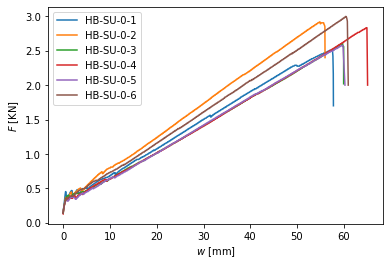

In [5]:
#HB-SU-0
%matplotlib inline
excel_file = join('./verification_data/hei20','hei20.xlsx')
data = pd.read_excel(excel_file, 'HB-SU-0')

for i in range(0,data.shape[1],2):
    plt.plot(data.iloc[:, i+1],data.iloc[:, i], label = data.columns.tolist()[i][0:-2])
w_1= data['HB-SU-0-1_w']  ; f_1= data['HB-SU-0-1_F'] ; ver_data1 = [w_1, f_1/4]; #plt.plot(w_1,f_1, label = 'HB-SU-0-1')
w_2= data['HB-SU-0-2_w']  ; f_2= data['HB-SU-0-2_F'] ; ver_data2 = [w_2, f_2/4]; #plt.plot(w_2,f_2, label = 'HB-SU-0-2')
w_3= data['HB-SU-0-3_w']  ; f_3= data['HB-SU-0-3_F'] ; ver_data3 = [w_3, f_3/4]; #plt.plot(w_3,f_3, label = 'HB-SU-0-3')
w_4= data['HB-SU-0-4_w']  ; f_4= data['HB-SU-0-4_F'] ; ver_data4 = [w_4, f_4/4]; #plt.plot(w_4,f_4, label = 'HB-SU-0-4')
w_5= data['HB-SU-0-5_w']  ; f_5= data['HB-SU-0-5_F'] ; ver_data5 = [w_5, f_5/4]; #plt.plot(w_5,f_5, label = 'HB-SU-0-5')
w_6= data['HB-SU-0-6_w']  ; f_6= data['HB-SU-0-6_F'] ; ver_data6 = [w_6, f_6/4]; #plt.plot(w_6,f_6, label = 'HB-SU-0-6')
plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [KN]');

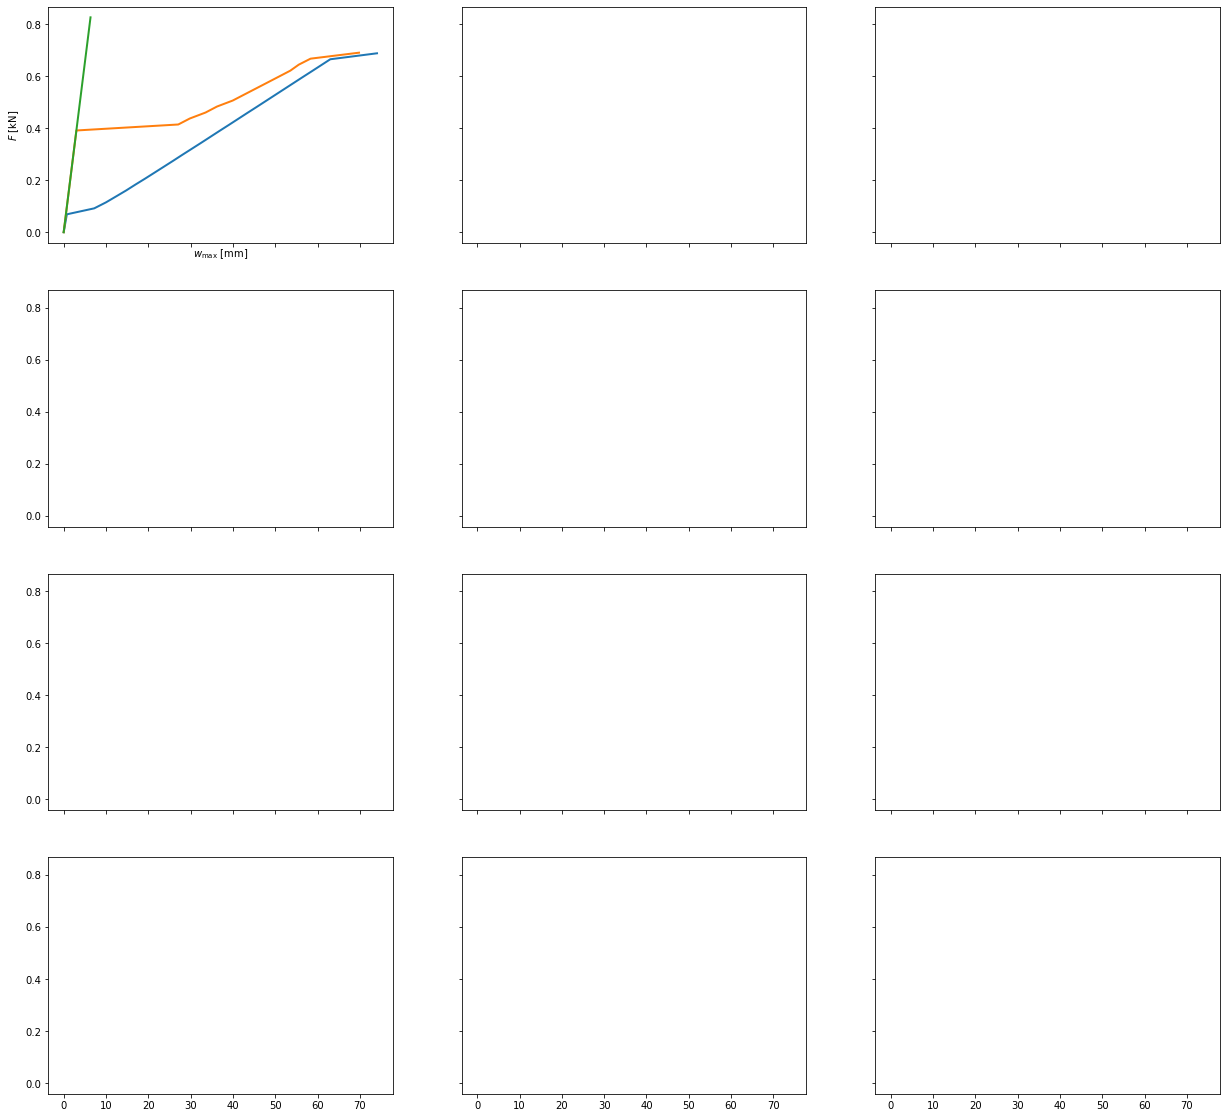

In [44]:
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0008
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[1]

# parameters = ['l', 'b', 'h', 'E', 'E_s', 'f_sy', 'eps_cr', 'rho',
#               'beta_tu', 'v_f', 'omega', 'psi', 'mu', 'alpha', 'lambda_cu']

dp.beam_design.L = 3 * 320
map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2,  #  eps_tu/eps_cr
            b = 45,
            h = 30,
            rho = 7.24/30/150/2,
            v_f = 1.0,
            E = 39500,
            E_s = 240000, 
            f_sy = 2712 , 
            eps_cr = 0.000163, 
            omega = .68, #eps_cy/eps_cr
            psi = 0.0113/0.00016, #eps_sy_j/eps_cr
            mu = .2, #σp/σcr
            alpha = 0.75, #z_j/h
            lambda_cu = 0.11/0.00016) #eps_cu/eps_cr
dp.mc.A_j = np.array([3.62, 3.62])  # A_j[0] for tension steel / A_j[1] for compression steel
dp.mc.z_j = np.array([8, 22])
dp.mc.E_j = np.array([240000, 240000])
dp.mc.eps_sy_j = np.array([0.0113, 0.0113])

nrows=4
ncols=3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(21,20), sharex=True, sharey=True)

# Parmetric study of E_j
parameter_ranges = {
#     l : (1,2,1),
#     'B' : (1,2,1),
#     'H': (2,80,3),
#     "E": (1,2,1),
#     "E_s": (1,2,1),
#     "f_sy": (1,2,1),
#     "eps_cr": (1,2,1),
#     "rho": (1,2,1),
#     "beta_tu": (1,2,1),
#     "v_f": (1,2,1),
#     "omega": (1,2,1),
#     "psi": (1,2,1),
#     "mu": (1,2,1),
#     "alpha": (1,2,1),
#     "lambda_cu": (1,2,1)
#     'E_ct': (20000, 50000, 3),
#     'E_cc': (20000, 50000, 3),
    'eps_cr': (0.0001, 0.001, 3)
}

col = 0
row = 0
for param_name, param_range in parameter_ranges.items():
    if param_name == 'B':
        for value in np.linspace(*param_range):
            setattr(dp.mc.cross_section_shape, param_name, value)
            dp.plot_fw(axes[row, col])
    else:
        for value in np.linspace(*param_range):
            setattr(dp.mc, param_name, value)
            dp.plot_fw(axes[row, col])
    if col < ncols -1:
        col +=1
    else:
        row += 1
        col = 0

# for B in np.linspace(1, 80, 4):
#     dp.mc.cross_section_shape.B = B
#     dp.plot_fw(axes[0, 0])